In [13]:
import tensorflow as tf
import keras
from tensorflow import keras

# model = tf.keras.models.load_model('20200621-model-cw-64-1')
# model = tf.keras.models.load_model('20200621-model-cw-64-1', custom_objects={
#     'Adam': lambda **kwargs: hvd.DistributedOptimizer(keras.optimizers.Adam(**kwargs))
# })

# model_filepath = '20200621#2-model-test2-samson'
# model_filepath = '20200621-model-cw-64-1-crop'
model_filepath = '20200621-model-cw-64-1-gcs'


model = tf.keras.models.load_model(
    model_filepath,
    custom_objects=None,
    compile=False
)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 128 73856       conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 64, 64, 128)  147584      conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

In [14]:
from os import listdir
import random

file_list = list()
for filename in listdir('raw_data_set'):
    file_list.append(filename)
# print(file_list)

test_files = random.choices(file_list, k = 3)
# print(test_files)



/home/wah/cohort9-group-project-2/cw/20200622/20200622-load_model.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from skimage.transform import resize
/home/wah/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 36841 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


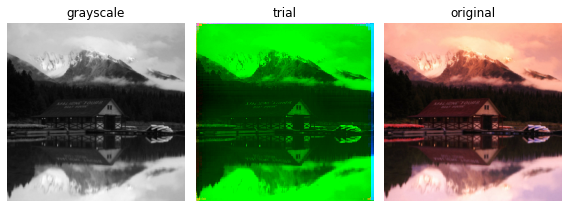

/home/wah/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 55295 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


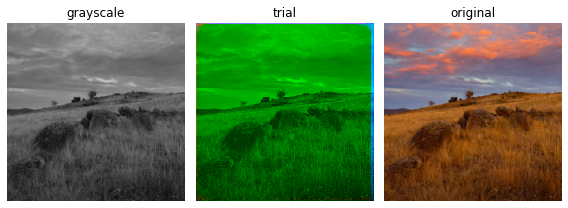

/home/wah/.local/lib/python3.6/site-packages/skimage/color/colorconv.py:1128: UserWarning: Color data out of range: Z < 0 in 53504 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


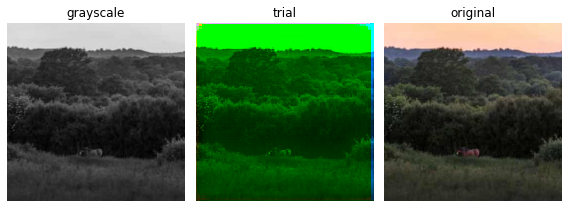

In [15]:
## Test Data
# Visualize the hallucinated output on the test dataset to understand how well the model has learnt the image colorization task

import os
from os import listdir
import random
import numpy as np

import scipy as sp
import scipy.ndimage as spi

from skimage.io import imsave,imshow
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.engine import Layer
from keras.layers import Reshape, merge, concatenate
from keras.layers import Input,Activation, Dense, Dropout, Flatten
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose 

from keras.layers.core import RepeatVector, Permute
from keras.layers.normalization import BatchNormalization

from keras.callbacks import TensorBoard 

from keras.models import Sequential, Model

import tensorflow as tf

DIM = 256

#Make predictions on validation images
IMG_DIR = './raw_data_set/'
sample_img = []
for filename in test_files:
    sample_img.append(sp.misc.imresize(load_img(IMG_DIR+filename), 
                                     (DIM, DIM)))
sample_img = np.array(sample_img, 
                    dtype=float)
sample_img = 1.0/255*sample_img
sample_img = gray2rgb(rgb2gray(sample_img))

sample_img = rgb2lab(sample_img)[:,:,:,0]
sample_img = sample_img.reshape(sample_img.shape+(1,))

## load pretrained VGG16
#Load weights
vgg16 = VGG16(weights='imagenet', include_top=True)
vgg16.graph = tf.get_default_graph()
vgg16.output_shape

#embedding input
#Create embedding
def create_vgg_embedding(grayscaled_rgb):
    gs_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (224, 224, 3), 
                   mode='constant')
        gs_rgb_resized.append(i)
    gs_rgb_resized = np.array(gs_rgb_resized)
    gs_rgb_resized = preprocess_input(gs_rgb_resized)
    with vgg16.graph.as_default():
      embedding = vgg16.predict(gs_rgb_resized)
    return embedding

sample_img_embed = create_vgg_embedding(sample_img)

# Test model
output_img = model.predict([sample_img, sample_img_embed])
output_img = output_img * 128

filenames = test_files

# Output colorizations
for i in range(len(output_img)):
    fig = plt.figure(figsize=(8,8))
    final_img = np.zeros((DIM,DIM, 3))
    
    # add grayscale channel
    final_img[:,:,0] = sample_img[i][:,:,0]
    
    # add predicted channel
    final_img[:,:,1:] = output_img[i]
    
    img_obj = load_img(IMG_DIR+filenames[i])
    
    fig.add_subplot(1, 3, 1)
    plt.axis('off')
    
    grayed_img = gray2rgb(
                  rgb2gray(
                      img_to_array(
                          img_obj)/255)
                  )
    plt.imshow(grayed_img)
    plt.title("grayscale")
    
    fig.add_subplot(1, 3, 2)
    plt.axis('off')
    imshow(lab2rgb(final_img))
    plt.title("trial")
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(img_obj)
    plt.title("original")
    plt.axis('off')
    plt.show()
